# Problem 1.1


********************************************************
Info of #GoHawks
    Average number of tweets per hour: 325.37159130433116
    Average number of followers per user: 1588.1886629300582
    Average number of followers per tweet: 2203.931767444827
    Average number of retweets per tweet: 2.014617085512608

********************************************************
Info of #GoPatriots
    Average number of tweets per hour: 45.69451057356203
    Average number of followers per user: 1294.4693664626748
    Average number of followers per tweet: 1401.8955093016164
    Average number of retweets per tweet: 1.4000838670326319

********************************************************
Info of #NFL
    Average number of tweets per hour: 441.3234311373958
    Average number of followers per user: 4221.076987865717
    Average number of followers per tweet: 4653.252285502502
    Average number of retweets per tweet: 1.5385331089011056


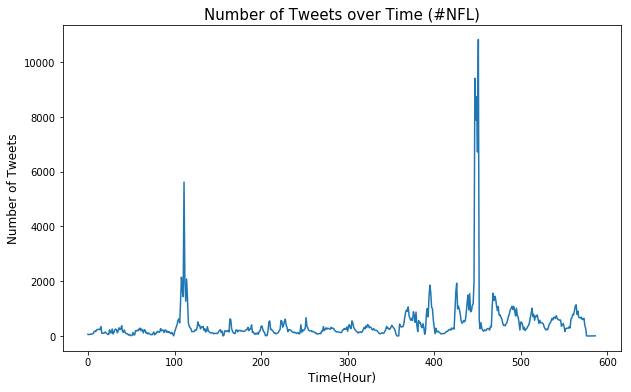


********************************************************
Info of #Patriots
    Average number of tweets per hour: 834.5555091641886
    Average number of followers per user: 1695.2710621477224
    Average number of followers per tweet: 3309.978828415827
    Average number of retweets per tweet: 1.7828156491659402

********************************************************
Info of #SB49
    Average number of tweets per hour: 1419.8879074871902
    Average number of followers per user: 2250.850257742912
    Average number of followers per tweet: 10267.31684948685
    Average number of retweets per tweet: 2.5111487863247035

********************************************************
Info of #SuperBowl
    Average number of tweets per hour: 2302.5004018833274
    Average number of followers per user: 3798.679117085927
    Average number of followers per tweet: 8858.974662784603
    Average number of retweets per tweet: 2.3882723999030224


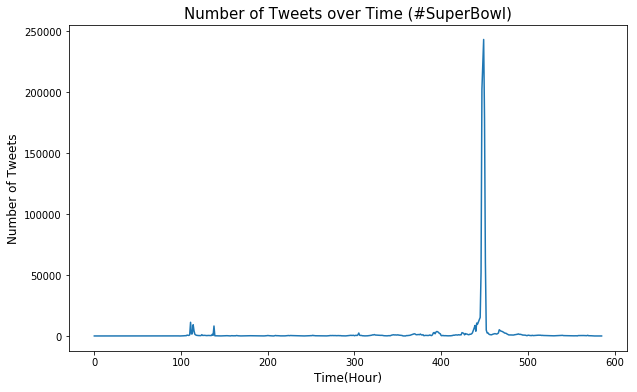

In [1]:
import json
import matplotlib.pyplot as plt
import datetime, time
import pytz
from datetime import timedelta


#================================= Plot the Histogram ==============================
def plot_histogram(time_stamps, hashtag):
    hourly_tweet_count = [0] * (int((max(time_stamps) - min(time_stamps)) / timedelta(hours=1))+1)
    start_time = min(time_stamps)
    for time_stamp in time_stamps:
        hourly_tweet_count[int((time_stamp-start_time) / timedelta(hours=1))] += 1
           
#     plt.figure(figsize = (12,8))
#     plt.bar([i for i in range(0,len(hourly_tweet_count))], hourly_tweet_count, 1, align='edge', color = 'k')
#     hours_passed = (max(time_stamps) - min(time_stamps)) / timedelta(hours=1)
#     plt.axis([0,hours_passed+ 1,0,int(max(hourly_tweet_count)*1.03)])
    plt.figure(figsize = (10,6))
    plt.plot(hourly_tweet_count)
    plt.xlabel('Time(Hour)', fontsize = 12)
    plt.ylabel('Number of Tweets', fontsize = 12)
    plt.title('Number of Tweets over Time (' + hashtag + ')', fontsize = 15)
    plt.show()        
#==============================================================================


#=================== Get required Information =================
hashtag_dict = {'#GoHawks' : 'tweets_#gohawks.txt',
                '#GoPatriots' : 'tweets_#gopatriots.txt',
                '#NFL' : 'tweets_#nfl.txt',
                '#Patriots' : 'tweets_#patriots.txt',
                '#SB49' : 'tweets_#sb49.txt',
                '#SuperBowl' : 'tweets_#superbowl.txt'}

def get_info(hashtag):
    time_stamps = []
    followers_of_users = dict([])
    num_of_followers = []
    num_of_retweets = []
    
    # Extract data from file
    input_file = open('./tweet_data/'+hashtag_dict[hashtag])
    for line in input_file:
        data = json.loads(line)
        temp = data['citation_date']
        pst_tz = pytz.timezone('US/Pacific')
        
        date_time = datetime.datetime.fromtimestamp(temp, pst_tz)
        time_stamps.append(date_time)
        num_of_retweets.append(data['metrics']['citations']['total'])
        num_of_followers.append(data['author']['followers'])
        
        user_name = data['author']['nick']
        if user_name in followers_of_users:
            followers_of_users[user_name].append(data['author']['followers'])
        else:
            followers_of_users[user_name] = [data['author']['followers']]
    input_file.close()
    
    
    # Calculate related parameters
    total_number_of_tweets = float(len(time_stamps))
    hours_passed = (max(time_stamps) - min(time_stamps)) / timedelta(hours=1)
    
    followers = []
    for user in followers_of_users:
        followers.append(float(sum(followers_of_users[user]))/float(len(followers_of_users[user])))
        
    total_number_of_retweets = float(sum(num_of_retweets))
    
    #---------------------------- Print results -------------------------------
    print ('\n********************************************************')
    print ('Info of', hashtag)
    # print ('    Total number of tweets:', len(time_stamps))
    # print ('    Total number of users:', len(followers))
    print ('    Average number of tweets per hour:', total_number_of_tweets/hours_passed)
    print ('    Average number of followers per user:', sum(followers)/len(followers))
    print ('    Average number of followers per tweet:', sum(num_of_followers)/len(num_of_followers))
    print ('    Average number of retweets per tweet:', total_number_of_retweets/total_number_of_tweets)
    
    if hashtag in ['#NFL', '#SuperBowl']:
        plot_histogram(time_stamps, hashtag)
#==============================================================================

for key in hashtag_dict:
    get_info(key)




# Problem 1.2

Predicted: Number of tweets in next hour
Features: 
 Number of tweets (hashtag of interest)
 Total number of retweets (hashtag of interest)
 Sum of the number of followers of the users posting the hashtag
 Maximum number of followers of the users posting the hashtag
 Time of the day (which could take 24 values that represent hours of the day with
respect to a given time zone)

In [20]:
import os
import json
import datetime
import statsmodels.api as sm
import os.path
from datetime import timedelta

hashtag_dict = {'#GoHawks' : 'tweets_#gohawks.txt',
                '#GoPatriots' : 'tweets_#gopatriots.txt',
                '#NFL' : 'tweets_#nfl.txt',
                '#Patriots' : 'tweets_#patriots.txt',
                '#SB49' : 'tweets_#sb49.txt',
                '#SuperBowl' : 'tweets_#superbowl.txt'}

######## the function extracts the five mentioned features for the hashtag stored in "file"##########
def extract_features(key):
    data = open("./tweet_data/"+hashtag_dict[key])
    features = {}
    users = {} #dictionnary of sets that stores unique users per hour
    
    for tweet in data:
        tweet_dict = json.loads(tweet) #extract json data as dictionary
        totalFollowers = tweet_dict["author"]["followers"]
        retweets = tweet_dict["metrics"]["citations"]["total"]
        user = tweet_dict["tweet"]["user"]["id"] 
        tweet_time = tweet_dict["firstpost_date"] 
        tweet_time = datetime.datetime.fromtimestamp(tweet_time) 
        new_tweet_time = datetime.datetime(tweet_time.year, tweet_time.month, tweet_time.day, tweet_time.hour, 0, 0)
        new_tweet_time = str(new_tweet_time)
            
        if new_tweet_time not in features: #if that timestamp has not been seen before
            features[new_tweet_time] = {'totalTweets':0, 'retweets':0,'time':-1, 'followers':0, 'max_followers':0}
            users[new_tweet_time] = set([])
        features[new_tweet_time]['totalTweets'] += 1
        features[new_tweet_time]['retweets'] += retweets
        features[new_tweet_time]['time'] = tweet_time.hour
        if user not in users[new_tweet_time]: 
            users[new_tweet_time].add(user)
            features[new_tweet_time]['followers'] += totalFollowers
            if totalFollowers > features[new_tweet_time]['max_followers']:
                features[new_tweet_time]['max_followers'] = totalFollowers
    return features



# this function extracts the actual ground truth values of data and the data used for predicting the value for the next hour
def extract_labels(features_input):
    features = dict()
    for timeHour in features_input:
        current_time = datetime.datetime.strptime(timeHour, "%Y-%m-%d %H:%M:%S")
        features[current_time] = features_input[timeHour]   
    train_data = []
    ground_truths = []
    
    start_time = min(features.keys()) 
    end_time = max(features.keys())    
    
    current_time = start_time
    while current_time <= end_time: 
        
        next_time = current_time+timedelta(hours=1) 
        if next_time in features: # if data for next hour is already available
            nextTotalTweets = features[next_time]['totalTweets']  # assign the known value to tweet count for next hour
        else :
            nextTotalTweets = 0  # initilaise tweet count for next hour to zero if data is not available
        
        if current_time in features: 
            ground_truths.append([nextTotalTweets]) # the value to be predicted it the tweet count for next hour, so ground truth contains value for next hour
            train_data.append(list(features[current_time].values())) # treat data for current time as training data
        else: # data for current time stamp is not available, assume all values to be zero
            temp = {'totalTweets':0, 'retweets':0, 'followers':0, 'max_followers':0, 'time':current_time.hour}    
            train_data.append(list(temp.values()))
            ground_truths.append([nextTotalTweets])
        current_time = next_time
    return train_data, ground_truths


for key in hashtag_dict:
    features = extract_features(key)
    train_data, ground_truths = extract_labels(features)
    # train_data should be list not dict.values()!!!!
    train_data = sm.add_constant(train_data)
    regressionModel = sm.OLS(ground_truths, train_data)
    fitRegressionModel = regressionModel.fit()
    print ( "Details for Linear Regression Model for " + hashtag_dict[key])
    print ('#######################################################################')
    print (fitRegressionModel.summary())
    print ('#######################################################################')
    print ('\n\n\n\n\n')


Details for Linear Regression Model for tweets_#gohawks.txt
#######################################################################
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     186.0
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          8.81e-139
Time:                        01:08:32   Log-Likelihood:                -7817.0
No. Observations:                 973   AIC:                         1.565e+04
Df Residuals:                     967   BIC:                         1.568e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]

# Problem 1.3

best _Features 0--0
Lable _curent totalTweets


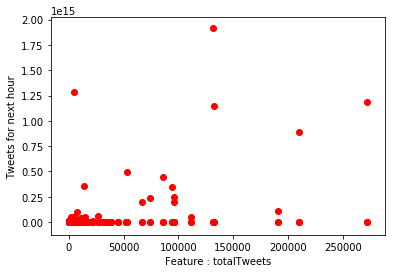

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     189.7
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          2.34e-206
Time:                        18:58:41   Log-Likelihood:                -7648.6
No. Observations:                 973   AIC:                         1.532e+04
Df Residuals:                     963   BIC:                         1.537e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2665     28.654      0.044      0.9

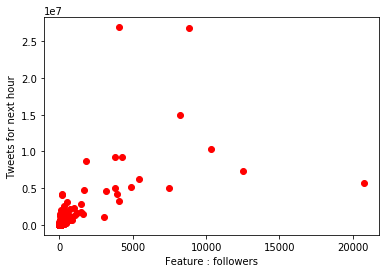

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     189.7
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          2.34e-206
Time:                        18:58:41   Log-Likelihood:                -7648.6
No. Observations:                 973   AIC:                         1.532e+04
Df Residuals:                     963   BIC:                         1.537e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2665     28.654      0.044      0.9

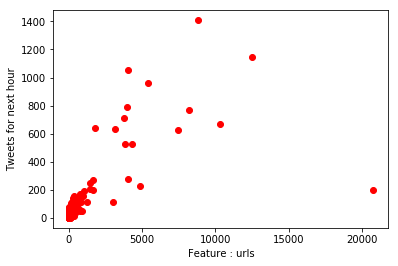

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     189.7
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          2.34e-206
Time:                        18:58:41   Log-Likelihood:                -7648.6
No. Observations:                 973   AIC:                         1.532e+04
Df Residuals:                     963   BIC:                         1.537e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2665     28.654      0.044      0.9

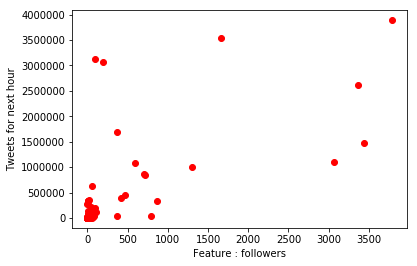

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     284.8
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          5.83e-223
Time:                        18:58:43   Log-Likelihood:                -4290.0
No. Observations:                 684   AIC:                             8600.
Df Residuals:                     674   BIC:                             8645.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.7719      6.733      0.263      0.7

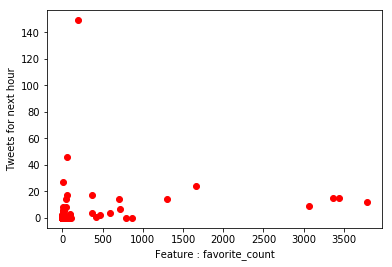

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     284.8
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          5.83e-223
Time:                        18:58:43   Log-Likelihood:                -4290.0
No. Observations:                 684   AIC:                             8600.
Df Residuals:                     674   BIC:                             8645.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.7719      6.733      0.263      0.7

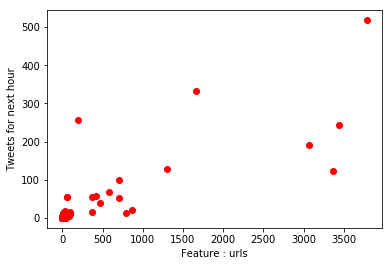

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     284.8
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          5.83e-223
Time:                        18:58:43   Log-Likelihood:                -4290.0
No. Observations:                 684   AIC:                             8600.
Df Residuals:                     674   BIC:                             8645.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.7719      6.733      0.263      0.7

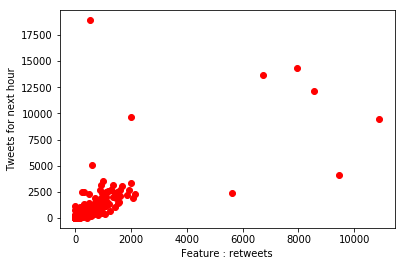

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     261.5
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          3.55e-246
Time:                        18:59:06   Log-Likelihood:                -6840.1
No. Observations:                 927   AIC:                         1.370e+04
Df Residuals:                     917   BIC:                         1.375e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         30.6816     18.207      1.685      0.0

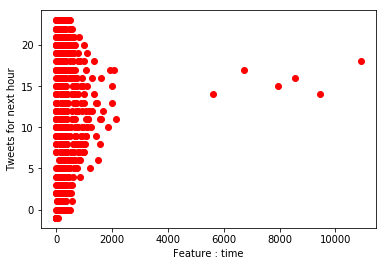

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     261.5
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          3.55e-246
Time:                        18:59:06   Log-Likelihood:                -6840.1
No. Observations:                 927   AIC:                         1.370e+04
Df Residuals:                     917   BIC:                         1.375e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         30.6816     18.207      1.685      0.0

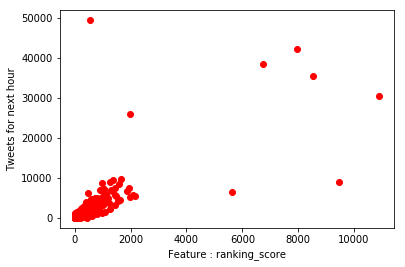

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     261.5
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          3.55e-246
Time:                        18:59:06   Log-Likelihood:                -6840.1
No. Observations:                 927   AIC:                         1.370e+04
Df Residuals:                     917   BIC:                         1.375e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         30.6816     18.207      1.685      0.0

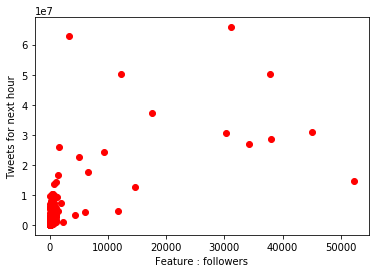

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     377.2
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          1.03e-309
Time:                        18:59:46   Log-Likelihood:                -8641.6
No. Observations:                 981   AIC:                         1.730e+04
Df Residuals:                     971   BIC:                         1.735e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -65.2812     71.623     -0.911      0.3

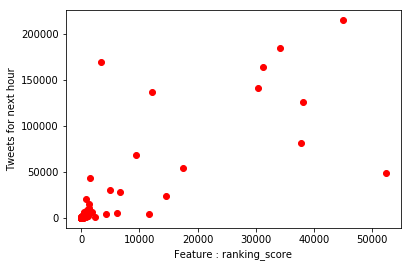

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     377.2
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          1.03e-309
Time:                        18:59:47   Log-Likelihood:                -8641.6
No. Observations:                 981   AIC:                         1.730e+04
Df Residuals:                     971   BIC:                         1.735e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -65.2812     71.623     -0.911      0.3

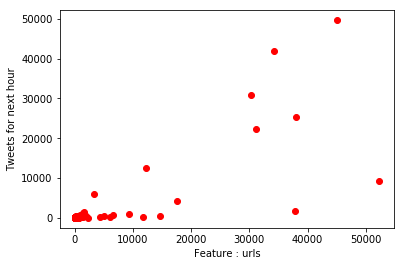

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     377.2
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          1.03e-309
Time:                        18:59:47   Log-Likelihood:                -8641.6
No. Observations:                 981   AIC:                         1.730e+04
Df Residuals:                     971   BIC:                         1.735e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -65.2812     71.623     -0.911      0.3

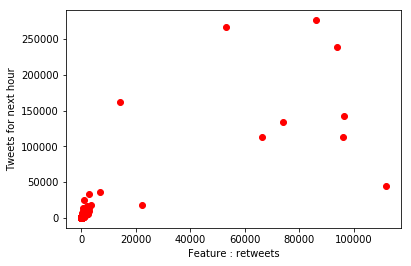

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     402.7
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          3.69e-241
Time:                        19:00:55   Log-Likelihood:                -5623.0
No. Observations:                 583   AIC:                         1.127e+04
Df Residuals:                     573   BIC:                         1.131e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -95.6047    281.680     -0.339      0.7

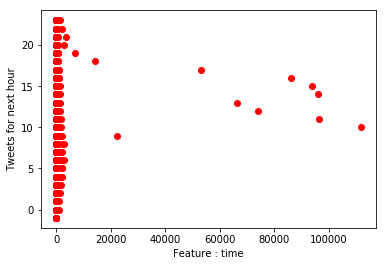

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     402.7
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          3.69e-241
Time:                        19:00:55   Log-Likelihood:                -5623.0
No. Observations:                 583   AIC:                         1.127e+04
Df Residuals:                     573   BIC:                         1.131e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -95.6047    281.680     -0.339      0.7

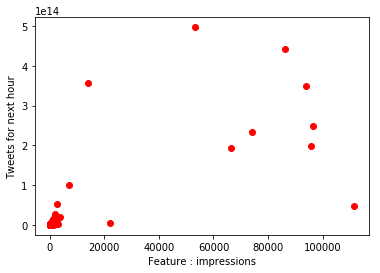

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     402.7
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          3.69e-241
Time:                        19:00:55   Log-Likelihood:                -5623.0
No. Observations:                 583   AIC:                         1.127e+04
Df Residuals:                     573   BIC:                         1.131e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -95.6047    281.680     -0.339      0.7

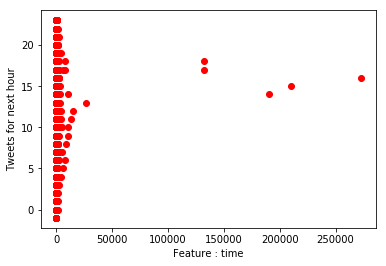

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     863.1
Date:                Mon, 19 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:02:48   Log-Likelihood:                -9506.3
No. Observations:                 964   AIC:                         1.903e+04
Df Residuals:                     954   BIC:                         1.908e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -140.0569    199.910     -0.701      0.4

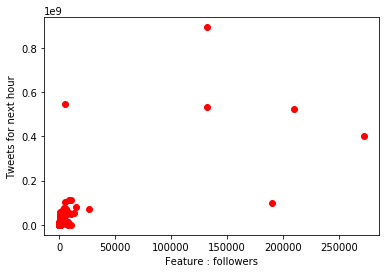

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     863.1
Date:                Mon, 19 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:02:48   Log-Likelihood:                -9506.3
No. Observations:                 964   AIC:                         1.903e+04
Df Residuals:                     954   BIC:                         1.908e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -140.0569    199.910     -0.701      0.4

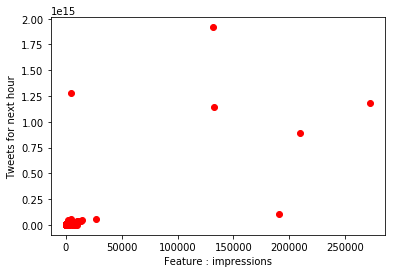

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     863.1
Date:                Mon, 19 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:02:48   Log-Likelihood:                -9506.3
No. Observations:                 964   AIC:                         1.903e+04
Df Residuals:                     954   BIC:                         1.908e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -140.0569    199.910     -0.701      0.4

In [26]:
import json
import datetime
from datetime import timedelta
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.figure as fig
import numpy as np


def extract_features(file):
    data = open("./tweet_data/" + training[file])
    features = {}
    impressions =0 
    users = {}  # dictionnary of sets that stores unique users per hour

    for tweet in data:
        tweet_dict = json.loads(tweet)  # extract json data as dictionary
        totalFollowers = tweet_dict["author"]["followers"]
        retweets = tweet_dict["metrics"]["citations"]["total"]
        user = tweet_dict["tweet"]["user"]["id"]
        impressions += tweet_dict['metrics']['impressions']
        tweet_time = tweet_dict["firstpost_date"]
        favorite_count = tweet_dict["tweet"]["favorite_count"]  # number of 'favourites' the tweet received
        ranking_score = tweet_dict["metrics"]["ranking_score"]  # stores rank of tweet
        urls = len(tweet_dict["tweet"]["entities"]["urls"])  # stores if URLs are present in the tweet
        if urls > 0:
            urls = 1
        else:
            urls = 0

        tweet_time = datetime.datetime.fromtimestamp(tweet_time)
        new_tweet_time = datetime.datetime(tweet_time.year, tweet_time.month, tweet_time.day, tweet_time.hour, 0, 0)
        new_tweet_time = str(new_tweet_time)

        if new_tweet_time not in features:  # if that timestamp has not been seen before
            features[new_tweet_time] = {'totalTweets': 0, 'retweets': 0, 'time': -1, 'followers': 0, 
                                         'favorite_count': 0, 'ranking_score': 0, 'urls': 0,'user_count':0,
                                        'impressions' : 0
                                        }
            users[new_tweet_time] = set([])
        features[new_tweet_time]['totalTweets'] += 1
        features[new_tweet_time]['retweets'] += retweets
        features[new_tweet_time]['time'] = tweet_time.hour
        features[new_tweet_time]['favorite_count'] += favorite_count
        features[new_tweet_time]['ranking_score'] += ranking_score
        features[new_tweet_time]['urls'] += urls
        features[new_tweet_time]['impressions'] += impressions

        if user not in users[new_tweet_time]:
            users[new_tweet_time].add(user)
            features[new_tweet_time]['user_count'] += 1
            features[new_tweet_time]['followers'] += totalFollowers
 

    return features


# this function extracts the actual ground truth values of data and the data used for predicting the value for the next hour
def extract_labels(features_input):
    features = dict()
    for timeHour in features_input:
        current_time = datetime.datetime.strptime(timeHour, "%Y-%m-%d %H:%M:%S")
        features[current_time] = features_input[timeHour]
    train_data = []
    ground_truths = []

    start_time = min(features.keys())
    end_time = max(features.keys())

    current_time = start_time
    while current_time <= end_time:

        next_time = current_time + timedelta(hours=1)
        if next_time in features:  # if data for next hour is already available
            nextTotalTweets = features[next_time]['totalTweets']  # assign the known value to tweet count for next hour
        else:
            nextTotalTweets = 0  # initilaise tweet count for next hour to zero if data is not available

        if current_time in features:
            ground_truths.append([nextTotalTweets])  # the value to be predicted it the tweet count for next hour, so ground truth contains value for next hour
            train_data.append(list(features[current_time].values()))  # treat data for current time as training data
        else:  # data for current time stamp is not available, assume all values to be zero
            temp =  {'totalTweets': 0, 'retweets': 0, 'time': -1, 'followers': 0, 
                                         'favorite_count': 0, 'ranking_score': 0, 'urls': 0,'user_count':0,
                                        'impressions' : 0
                                        }
            train_data.append(list(temp.values()))
            ground_truths.append([nextTotalTweets])
        current_time = next_time
    return train_data, ground_truths



training = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", "tweets_#nfl.txt", "tweets_#patriots.txt",
            "tweets_#sb49.txt", "tweets_#superbowl.txt"]
hashtags = ["#gohawks", "#gopatriots", "#nfl", "#patriots", "#sb49", "#superbowl"]
feature_names=['totalTweets','retweets','time','followers',
                                         'favorite_count','ranking_score', 'urls','user_count',
                                        'impressions' ]
best_features = [[1,4,7],[4,5,7],[2,3,6],[4,6,7],[2,3,9],[3,4,9]]

for i in range(len(training)):
    features = extract_features(i)
    train_data, ground_truths = extract_labels(features)
    train_data = sm.add_constant(train_data)
    regressionModel = sm.OLS(ground_truths, train_data)
    fitRegressionModel = regressionModel.fit()

    
    for j in best_features[i]:
        print ("best _Features "+str(i)+"--"+str(j-1))
        plt.gca().scatter(ground_truths,train_data[:,j],color='r')
        print ("Lable _curent "+feature_names[j-1])
        xlable="Feature : "+feature_names[j-1]
        plt.xlabel(xlable)
        plt.ylabel('Tweets for next hour')
        plt.show()
        print(fitRegressionModel.summary())

# Problem 1.4


# Problem 1.5